In [1]:
from kitchenoptimiser import io
from kitchenoptimiser.utils import draw_process

In [2]:
things = io.read_things(r'things.json')
places = io.read_locations(r'locations.json')
layout = io.read_layout(r'layout.json')
process_details = io.read_process_details(r'process_details2.json')

[('kettle', 'mugs', {'weight': 0.5}), ('kettle', 'fancy_mugs', {'weight': 0.5}), ('kettle', 'tea_stuff', {'weight': 1}), ('kettle', '0_Fridge', {'weight': 1})]


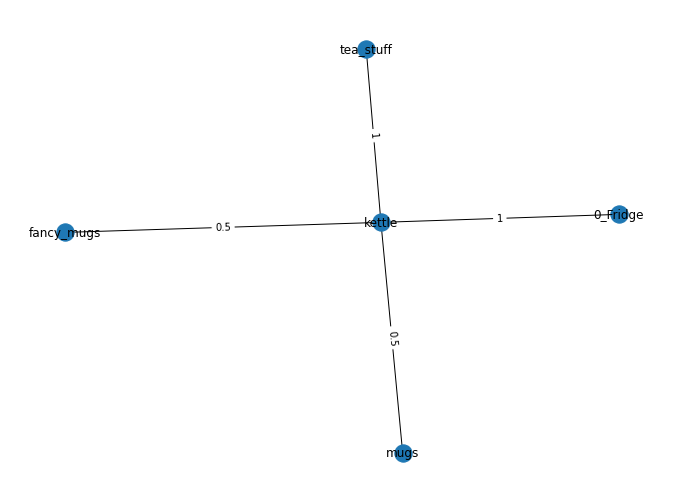

In [3]:
print(process_details['cup_of_tea']['process'].edges(data=True))
draw_process(process_details['cup_of_tea']['process'])

In [ ]:
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", dict, fitness=creator.FitnessMax)

def deap_create_gene(icls):
  return icls(create_gene(ALL_LOCATIONS, ALL_THINGS, FIXED_POSITIONS))

def deap_evaluate_minus(individual):
  "Need to return a tuple"
  return -get_fitness_distance_only(individual),

toolbox.register("individual", deap_create_gene, creator.Individual)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", deap_evaluate_minus)

def deap_best_individual(individuals):
  best_individual = max(individuals, key=lambda x: x.fitness.wvalues[0])
  return {k: v.name[:12] if type(v) == Thing else v for k, v in best_individual.items()}

def deap_min_fitness(individuals):
  return int(max(individuals, key=lambda x: x.fitness.wvalues[0]).fitness.wvalues[0])

s = tools.Statistics()
s.register("min_fitness", deap_min_fitness)
s.register("winner", deap_best_individual)